measurement_noise  1.9609142146685438e-07
process_noise  1346
a =  [[1.0e+00 2.5e-04]
 [0.0e+00 1.0e+00]]
k =  [[ 0.09674897]
 [19.68509311]]


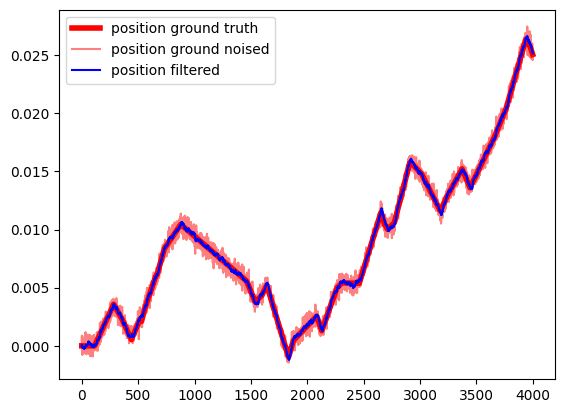

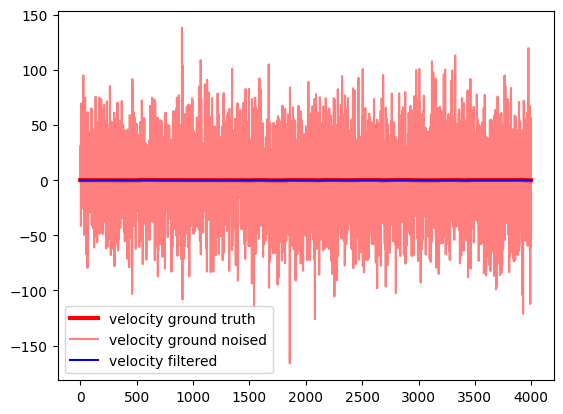

In [4]:
import numpy
import scipy
import matplotlib.pyplot as plt


def create_signal(n_steps, pos_std, vel_std, resolution = 4096, max_rpm = 1500, dt = 0.00025, p_change = 0.01):

    d_pos_max = (max_rpm/60.0)*resolution*dt*0.001
    d_pos     = 0

    pos_gt  = numpy.zeros(n_steps)
    vel_gt  = numpy.zeros(n_steps)

    pos_prev = 0.0
    pos      = 0.0

    for n in range(n_steps):
        #d_pos = 1
        pos+= d_pos

        # random change dirrection 
        if numpy.random.rand() < p_change:
            d_pos = d_pos_max*numpy.random.rand()
            if numpy.random.rand() < 0.5:
                d_pos = -d_pos

        pos_gt[n] = pos
        vel_gt[n] = (pos - pos_prev)/dt
        pos_prev  = pos

    # convert raw encoder into radians
    pos_gt = 2.0*numpy.pi*pos_gt/resolution
    vel_gt = 2.0*numpy.pi*vel_gt/resolution

  

    pos_gt_noised = pos_gt + pos_std*numpy.random.randn(n_steps)
    vel_gt_noised = vel_gt + vel_std*numpy.random.randn(n_steps)

    return pos_gt, pos_gt_noised, vel_gt, vel_gt_noised



class EncoderKalmanFilter:
    def __init__(self, dt = 0.00025, process_noise=0.01, measurement_noise=0.01):
        # Time step
        self.dt = dt

        # System dynamics matrix (A) and measurement matrix (H)
        self.A = numpy.array([[1, dt], [0, 1]])
        self.H = numpy.array([[1, 0]])


        # Single process noise variance
        q = process_noise
        self.Q = q * numpy.array([[dt**4 / 4, dt**3 / 2], [dt**3 / 2, dt**2]])

        # Measurement noise covariance (scalar)
        self.R = measurement_noise* numpy.array([[1]])

      
        # Compute steady-state error covariance and Kalman gain
        p = scipy.linalg.solve_discrete_are(self.A.T, self.H.T, self.Q, self.R)

        self.K = p @ self.H.T @ numpy.linalg.inv(self.H @ p @ self.H.T + self.R)

        # Initialize state estimates
        self.state = numpy.zeros((2, 1))

        print("a = ", self.A)
        print("k = ", self.K)

    def step(self, position_measurement):
        prediction_error = position_measurement - self.state[0][0]
        prediction_error = prediction_error*numpy.ones((1, 1))
        
        self.state = self.A@self.state + self.K@prediction_error

        return self.state[0][0], self.state[1][0]
    
    def step_scalar(self, position_measurement):
        k0 = self.K[0][0]
        k1 = self.K[1][0]


        prediction_error = position_measurement - self.state[0][0]

        position_new = self.state[0][0]  + self.state[1][0]*self.dt + k0*prediction_error
        velocity_new = self.state[1][0] + k1*prediction_error

        self.state[0][0] = position_new
        self.state[1][0] = velocity_new

        return self.state[0][0], self.state[1][0]


n_steps = 4000

dt = 0.00025
encoder_resolution = 4096
max_rpm = 1500.0

max_velocity = 1500.0*2.0*numpy.pi/60.0


quantization_error = 2.0*numpy.pi/encoder_resolution
measurement_noise  = (quantization_error**2)/12.0

print("measurement_noise ", measurement_noise)


process_noise = 1346 #(rad/s)^2

print("process_noise ", process_noise)





pos_gt, pos_gt_noised, vel_gt, vel_gt_noised = create_signal(n_steps, measurement_noise**0.5, process_noise**0.5, dt=dt, p_change=0.01)

kf = EncoderKalmanFilter(dt, process_noise=process_noise, measurement_noise=measurement_noise)


pos_fil = numpy.zeros(n_steps)
vel_fil = numpy.zeros(n_steps)

for n in range(n_steps):
    #pos_hat, vel_hat = kf.step(pos_gt_noised[n])
    pos_hat, vel_hat = kf.step_scalar(pos_gt_noised[n])
    pos_fil[n] = pos_hat
    vel_fil[n] = vel_hat

plt.plot(pos_gt,        label="position ground truth", color = "red", lw=4)
plt.plot(pos_gt_noised, label="position ground noised", color = "red", alpha=0.5)
plt.plot(pos_fil,       label="position filtered", color = "blue")
plt.legend()
plt.show()

plt.plot(vel_gt,        label="velocity ground truth", color = "red", lw=3)
plt.plot(vel_gt_noised, label="velocity ground noised", color = "red", alpha=0.5)
plt.plot(vel_fil,       label="velocity filtered", color = "blue")
plt.legend()
plt.show()